In [32]:
import csv
import cv2
import os
import pickle

import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import vgg16, inception_v3, resnet, xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image as image_method
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [2]:
RANDOM_STATE = 42

In [3]:
def load_dataset(target_size):
    x, y = [], []
    base_path = "./data/images/"

    for dir in os.listdir(base_path):
        for image in os.listdir(os.path.join(base_path, dir)):
            image_path = os.path.join(base_path, dir, image)
            image = Image.open(image_path)
            rgb_image = image.copy().convert("RGB")
            x.append(np.array(rgb_image.resize(target_size), dtype=np.uint8))
            y.append(dir)

    return x, y

In [4]:
target_size = (224, 224)

In [5]:
metadata = pd.read_csv("./data/metadata.csv")
meta_filter = metadata[["Channel", "Category"]]
meta_filter = meta_filter.drop_duplicates()
meta_dict = meta_filter.set_index("Channel")["Category"].to_dict()

In [6]:
x, y = load_dataset(target_size)

class: Abroad in Japan


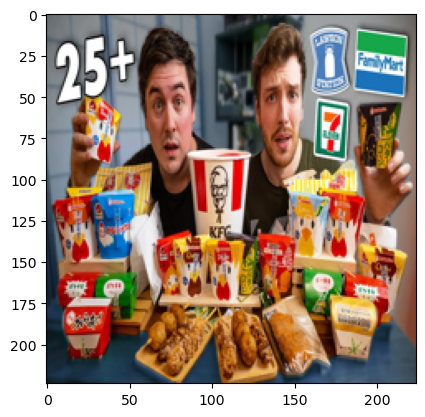

In [7]:
plt.imshow(x[100])
print(f"class: {y[100]}")

In [8]:
y = [meta_dict[item] for item in y]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

In [9]:
set_y = set(y)
count_dict = {}
for item in set_y:
    count_dict[item] = y.count(item)

In [10]:
print(count_dict)

{'Blog,Science': 27, 'Tech,News': 27, 'VideoGames': 253, 'Automobile': 188, 'Automobile,Comedy': 73, 'Comedy': 30, 'Informative': 215, 'Comedy,Entertainment': 88, 'Science': 281, 'Tech': 176, 'Blog,Comedy': 50, 'News': 193, 'Entertainment': 51, 'Tech,Informative': 29, 'Blog': 128, 'Food': 243, 'Blog,Entertainment': 29, 'Entertainment,Blog': 30, 'Entertainment,Comedy': 83, 'Tech,Comedy': 28, 'Comedy,Informative': 56, 'Food,Entertainment': 25}


In [11]:
with open("./results/Data/CSV/distribution_v1.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Category", "Count"])
    for category, occurence in count_dict.items():
        writer.writerow([category, occurence])

In [12]:
with open('le_classes.pkl', 'wb') as f:
    pickle.dump(le.classes_, f)

In [13]:
sm = SMOTE(random_state=RANDOM_STATE)
x = np.array(x)
n_samples, width, height, n_channels = x.shape

x_flat = x.reshape(n_samples, -1)

x, y_one_hot = sm.fit_resample(x_flat, y_one_hot)
x = x.reshape(-1, width, height, n_channels)

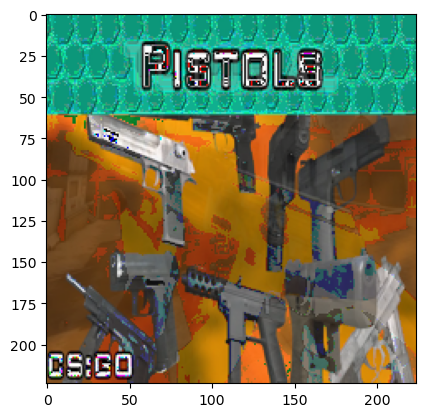

In [15]:
plt.imshow(x[6181])

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size=0.2, random_state=RANDOM_STATE)
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
x_train = np.array(x_train)
x_val = np.array(x_val)

print(f"Train size: {len(y_train)} --- Validation size: {len(y_val)} --- Test size: {len(y_test)}")

Train size: 3956 --- Validation size: 989 --- Test size: 1237


In [18]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [19]:
train_generator = train_datagen.flow(
    x_train,
    y_train, 
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x_val,
    y_val,
    batch_size=32,
    shuffle=False
)

test_generator = test_datagen.flow(
    x_test,
    y_test,
    batch_size=32,
    shuffle=False
)

# Grid Search for Transfer Learning Models

In [22]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

## VGG16

In [83]:
def create_vgg16_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [85]:
model = KerasClassifier(build_fn=create_vgg16_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/20
31/31 [==============================] - 2s 52ms/step - loss: 2.2139 - accuracy: 0.1232 - val_loss: 0.5908 - val_accuracy: 0.2168 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 1s 46ms/step - loss: 0.4196 - accuracy: 0.3391 - val_loss: 0.3529 - val_accuracy: 0.2141 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 1s 47ms/step - loss: 0.2485 - accuracy: 0.4725 - val_loss: 0.3108 - val_accuracy: 0.2276 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 1s 47ms/step - loss: 0.1667 - accuracy: 0.5193 - val_loss: 0.2553 - val_accuracy: 0.2547 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 1s 46ms/step - loss: 0.1421 - accuracy: 0.5244 - val_loss: 0.2580 - val_accuracy: 0.3550 - lr: 0.0010
Epoch 6/20
31/31 [==============================] - 1s 48ms/step - loss: 0.1203 - accuracy: 0.6222 - val_loss: 0.2237 - val_accuracy: 0.3388 - lr: 0.0010
Epoch 7/20
31/3

## InceptionV3

In [89]:
def create_inceptionv3_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [90]:
model = KerasClassifier(build_fn=create_inceptionv3_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/20
31/31 [==============================] - 5s 89ms/step - loss: 12.5501 - accuracy: 0.0886 - val_loss: 4.3645 - val_accuracy: 0.1057 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 1s 46ms/step - loss: 4.3402 - accuracy: 0.1059 - val_loss: 4.0687 - val_accuracy: 0.1165 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 1s 46ms/step - loss: 2.6693 - accuracy: 0.1314 - val_loss: 1.8285 - val_accuracy: 0.0867 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 1s 46ms/step - loss: 3.0600 - accuracy: 0.1293 - val_loss: 1.6413 - val_accuracy: 0.0949 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 1s 42ms/step - loss: 2.0644 - accuracy: 0.1507 - val_loss: 1.7302 - val_accuracy: 0.0407 - lr: 0.0010
Epoch 6/20
31/31 [==============================] - 1s 42ms/step - loss: 2.4299 - accuracy: 0.1039 - val_loss: 1.8738 - val_accuracy: 0.1057 - lr: 0.0010
Epoch 7/20
31/

## ResNet50

In [91]:
def create_resnet50_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = resnet.ResNet50(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [92]:
model = KerasClassifier(build_fn=create_resnet50_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Epoch 1/20
31/31 [==============================] - 4s 81ms/step - loss: 1.7669 - accuracy: 0.1008 - val_loss: 0.3934 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 2s 50ms/step - loss: 0.4494 - accuracy: 0.3625 - val_loss: 0.3228 - val_accuracy: 0.3577 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 1s 47ms/step - loss: 0.2385 - accuracy: 0.5692 - val_loss: 0.3507 - val_accuracy: 0.3469 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 1s 47ms/step - loss: 0.1411 - accuracy: 0.7281 - val_loss: 0.3577 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 1s 47ms/step - loss: 0.1022 - accuracy: 0.8136 - val_loss: 0.4385 - val_accuracy: 0.3144 - lr: 0.0010
Epoch 6/20
31/31 [==============================] - 2s 51ms/step - loss: 0.0848 - accuracy: 0.8605 - val_loss: 0.3170 - val_accuracy: 0.4932 - lr: 0.0010
Epoch 7/20
31/31 [==============================] - 1s 47ms/step - loss: 0.0

## Xception

In [93]:
def create_xception_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = xception.Xception(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [94]:
model = KerasClassifier(build_fn=create_xception_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Epoch 1/20
31/31 [==============================] - 4s 95ms/step - loss: 5.7279 - accuracy: 0.0937 - val_loss: 3.1611 - val_accuracy: 0.1084 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 2s 65ms/step - loss: 2.3667 - accuracy: 0.1670 - val_loss: 1.8171 - val_accuracy: 0.1680 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 2s 61ms/step - loss: 1.6720 - accuracy: 0.2322 - val_loss: 2.7694 - val_accuracy: 0.1680 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 2s 66ms/step - loss: 1.2845 - accuracy: 0.2281 - val_loss: 1.1784 - val_accuracy: 0.1463 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 2s 62ms/step - loss: 1.0054 - accuracy: 0.2658 - val_loss: 1.2561 - val_accuracy: 0.1491 - lr: 0.0010
Epoch 6/20
31/31 [==============================] - 2s 64ms/step - loss: 0.8491 - accuracy: 0.2617 - val_loss: 1.0978 - val_accuracy: 0.1355 - lr: 0.0010
Epoch 7/20
31/31 [==============================] - 2s 65ms/step - loss: 0.7

# Transfer Learning

## Best Parameters:
VGG16: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 64, 'optimizer': 'rmsprop'} acc: 0.44  
InceptionV3: {'activation': 'softmax', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 128, 'optimizer': 'adam'} 0.26  
ResNet50: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 128, 'optimizer': 'adam'} 0.47  
XCeption: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 128, 'optimizer': 'adam'} 0.27  

In [27]:
model_vgg_16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=target_size+(3,))
model_inception_v3 = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=target_size+(3,))
model_resnet_50 = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=target_size+(3,))
model_xception = xception.Xception(weights='imagenet', include_top=False, input_shape=target_size+(3,))

In [34]:
model_dict = {
    'vgg_16': model_vgg_16,
    'inception_v3': model_inception_v3,
    'resnet_50': model_resnet_50,
    'xception': model_xception
}

for key, value in model_dict.items():
    for layer in value.layers:
        layer.trainable = False

In [38]:
dropout = 0.2
learning_rate = 1e-03
epochs = 50

In [36]:
for key, value in model_dict.items():
    model = Sequential()
    model.add(value)
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    if key == 'vgg_16':
        model.add(Dense(64, activation="relu"))
    else:
        model.add(Dense(128, activation="relu"))
    if key == 'inception_v3':
        model.add(Dense(len(le.classes_), activation="softmax"))
    else:
        model.add(Dense(len(le.classes_), activation="sigmoid"))
    model_dict[key] = model

Epoch 1/50
124/124 [==============================] - 24s 186ms/step - loss: 0.2649 - accuracy: 0.9315 - val_loss: 1.0489 - val_accuracy: 0.7745 - lr: 0.0010
Epoch 2/50
124/124 [==============================] - 23s 185ms/step - loss: 0.1914 - accuracy: 0.9393 - val_loss: 1.0125 - val_accuracy: 0.7705 - lr: 0.0010
Epoch 3/50
124/124 [==============================] - 23s 184ms/step - loss: 0.1854 - accuracy: 0.9416 - val_loss: 1.2077 - val_accuracy: 0.7533 - lr: 0.0010
Epoch 4/50
124/124 [==============================] - 23s 184ms/step - loss: 0.1728 - accuracy: 0.9474 - val_loss: 1.1297 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 5/50
124/124 [==============================] - 23s 185ms/step - loss: 0.1778 - accuracy: 0.9462 - val_loss: 1.5001 - val_accuracy: 0.7250 - lr: 0.0010
Epoch 6/50
124/124 [==============================] - 23s 186ms/step - loss: 0.1391 - accuracy: 0.9588 - val_loss: 1.1017 - val_accuracy: 0.7897 - lr: 0.0010
Epoch 7/50
124/124 [==============================] 

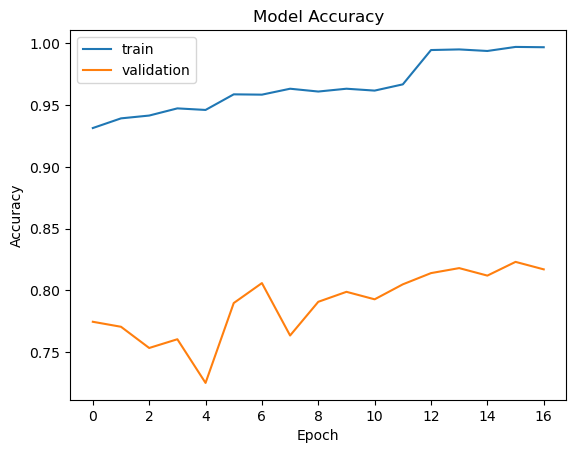

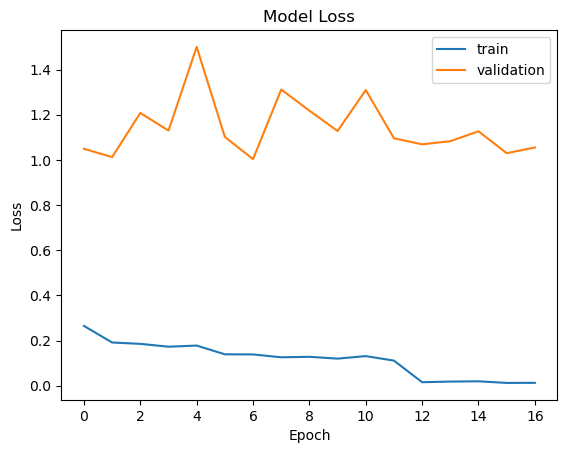

Epoch 1/50
124/124 [==============================] - 27s 194ms/step - loss: 0.6691 - accuracy: 0.8097 - val_loss: 2.0373 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 2/50
124/124 [==============================] - 23s 184ms/step - loss: 0.5572 - accuracy: 0.8316 - val_loss: 1.6061 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 3/50
124/124 [==============================] - 23s 184ms/step - loss: 0.5545 - accuracy: 0.8390 - val_loss: 1.4840 - val_accuracy: 0.6471 - lr: 0.0010
Epoch 4/50
124/124 [==============================] - 23s 183ms/step - loss: 0.4706 - accuracy: 0.8615 - val_loss: 1.9959 - val_accuracy: 0.6259 - lr: 0.0010
Epoch 5/50
124/124 [==============================] - 23s 183ms/step - loss: 0.5033 - accuracy: 0.8541 - val_loss: 1.8529 - val_accuracy: 0.6249 - lr: 0.0010
Epoch 6/50
124/124 [==============================] - 23s 184ms/step - loss: 0.4780 - accuracy: 0.8562 - val_loss: 1.6241 - val_accuracy: 0.6795 - lr: 0.0010
Epoch 7/50
124/124 [==============================] 

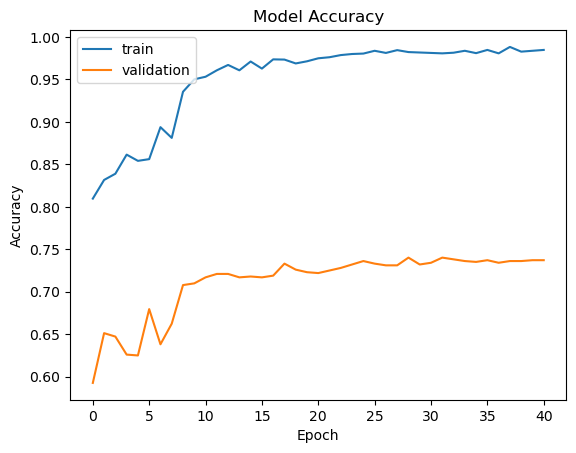

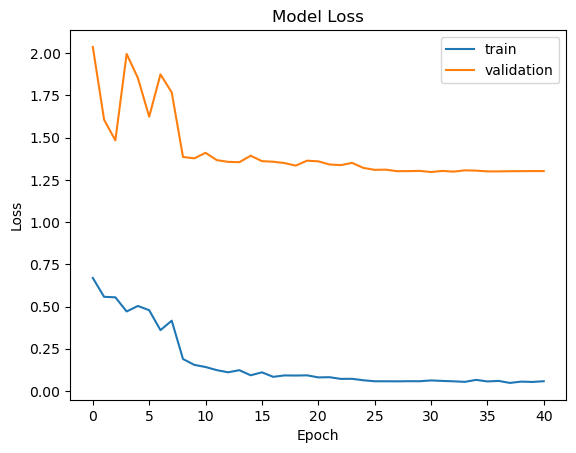

Epoch 1/50
124/124 [==============================] - 26s 190ms/step - loss: 3.5873 - accuracy: 0.0720 - val_loss: 2.9487 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 2/50
124/124 [==============================] - 23s 182ms/step - loss: 2.9376 - accuracy: 0.1107 - val_loss: 2.8202 - val_accuracy: 0.1618 - lr: 0.0010
Epoch 3/50
124/124 [==============================] - 23s 183ms/step - loss: 2.8636 - accuracy: 0.1271 - val_loss: 3.0231 - val_accuracy: 0.0647 - lr: 0.0010
Epoch 4/50
124/124 [==============================] - 23s 181ms/step - loss: 2.9802 - accuracy: 0.0667 - val_loss: 2.9491 - val_accuracy: 0.0657 - lr: 0.0010
Epoch 5/50
124/124 [==============================] - 22s 181ms/step - loss: 2.9519 - accuracy: 0.0832 - val_loss: 2.9480 - val_accuracy: 0.0789 - lr: 0.0010
Epoch 6/50
124/124 [==============================] - 23s 182ms/step - loss: 2.9126 - accuracy: 0.0945 - val_loss: 2.8699 - val_accuracy: 0.0981 - lr: 0.0010
Epoch 7/50
124/124 [==============================] 

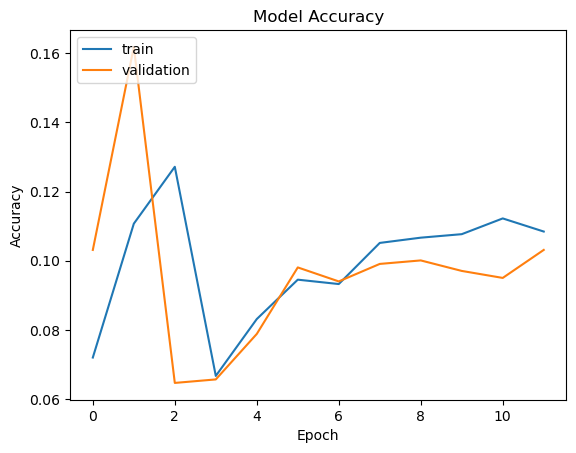

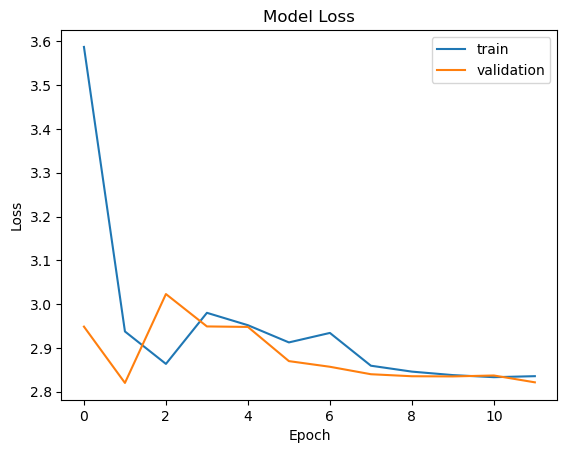

Epoch 1/50
124/124 [==============================] - 26s 192ms/step - loss: 3.4701 - accuracy: 0.2831 - val_loss: 1.9194 - val_accuracy: 0.4530 - lr: 0.0010
Epoch 2/50
124/124 [==============================] - 23s 183ms/step - loss: 1.5210 - accuracy: 0.5427 - val_loss: 1.5340 - val_accuracy: 0.5440 - lr: 0.0010
Epoch 3/50
124/124 [==============================] - 23s 188ms/step - loss: 1.2152 - accuracy: 0.6431 - val_loss: 1.5119 - val_accuracy: 0.5763 - lr: 0.0010
Epoch 4/50
124/124 [==============================] - 23s 184ms/step - loss: 0.9973 - accuracy: 0.6994 - val_loss: 1.5096 - val_accuracy: 0.5996 - lr: 0.0010
Epoch 5/50
124/124 [==============================] - 23s 183ms/step - loss: 0.8856 - accuracy: 0.7369 - val_loss: 1.6386 - val_accuracy: 0.5784 - lr: 0.0010
Epoch 6/50
124/124 [==============================] - 23s 184ms/step - loss: 0.7239 - accuracy: 0.7773 - val_loss: 1.5385 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 7/50
124/124 [==============================] 

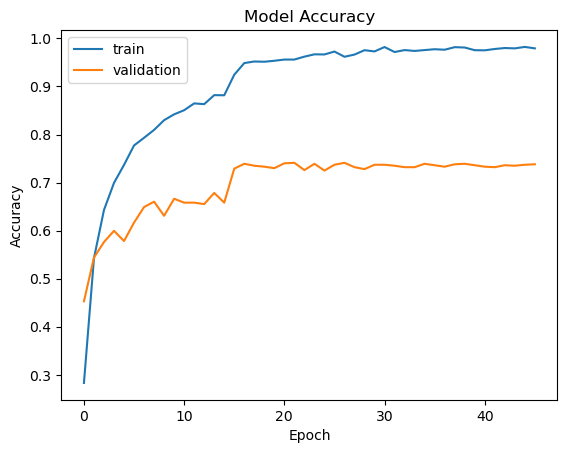

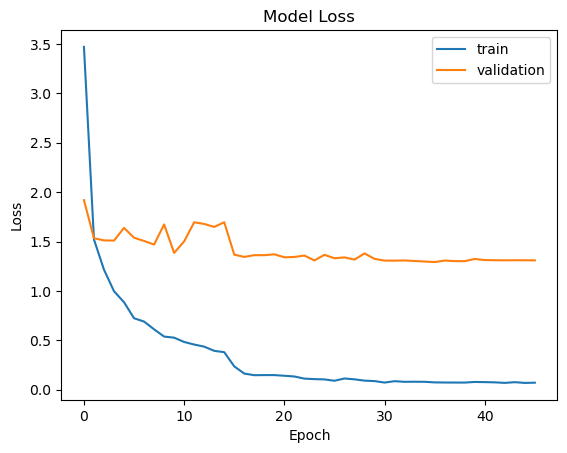

In [39]:
history_dict = {}

for key, value in model_dict.items():
    if key == 'vgg_16':
        value.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
    else:
        value.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

    history = value.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stop, reduce_lr],
    )

    history_dict[key] = history

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # plot training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

39/39 [==============================] - 2s 57ms/step
Accuracy of 16.98%
39/39 [==============================] - 2s 40ms/step
Accuracy of 4.04%
39/39 [==============================] - 2s 39ms/step
Accuracy of 4.69%
39/39 [==============================] - 2s 44ms/step
Accuracy of 4.85%


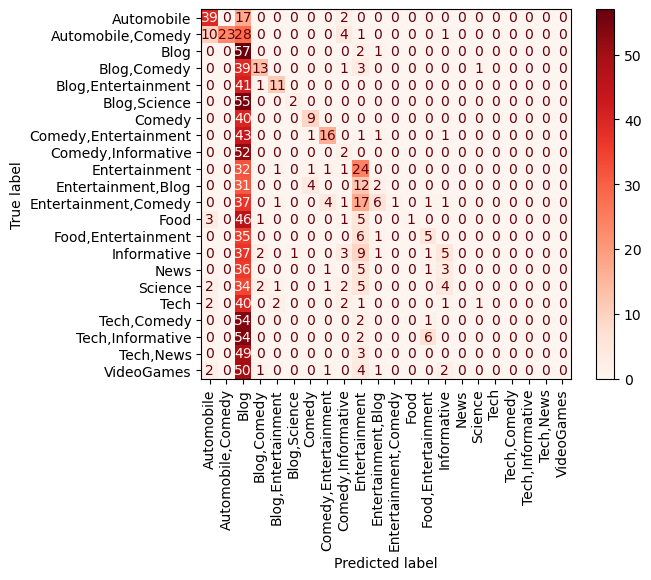

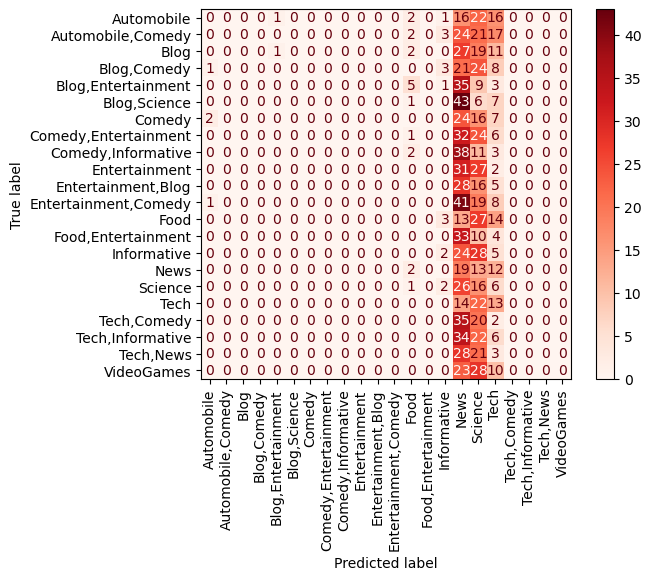

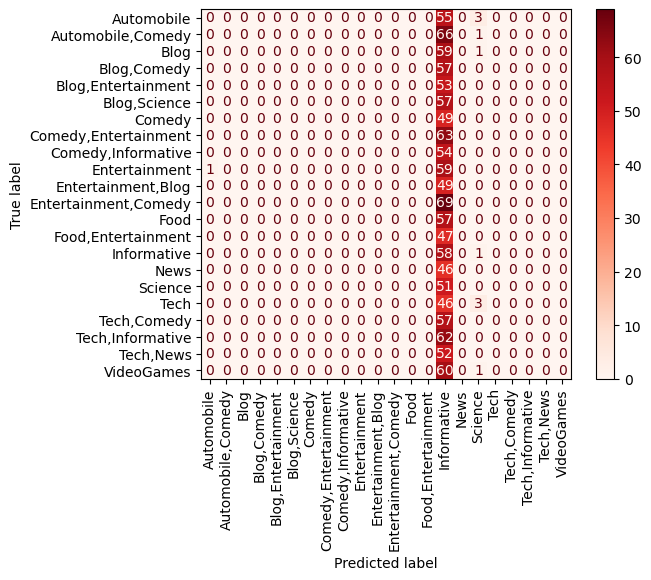

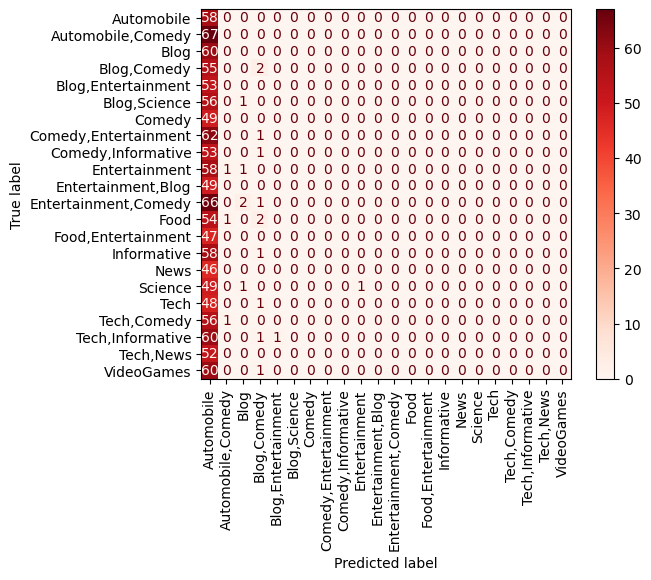

In [40]:
for key, value in model_dict.items():
    pred = value.predict(x_test)
    predictions = np.argmax(pred, axis=1)
    cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
    print(f"Accuracy of {round(acc*100, 2)}%")
    cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    cm_display.plot(cmap="Reds", xticks_rotation=90)

## Grid Search for Custom CNN

In [20]:
def create_custom_cnn(n_filter_1, n_filter_2, kernel_size, pool_size, n_hidden, activation):
    model = Sequential()
    model.add(Conv2D(n_filter_1, kernel_size=kernel_size, activation="relu", input_shape=target_size+(3,)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(n_filter_2, kernel_size=kernel_size, activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(n_hidden, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(len(le.classes_), activation=activation))
    model.compile(optimizer=Adam(learning_rate=1e-03), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [23]:
model = KerasClassifier(build_fn=create_custom_cnn)
param_grid = {
    'n_filter_1': [16, 32, 64],
    'n_filter_2': [16, 32, 64],
    'kernel_size': [3, 5],
    'pool_size': [2, 3],
    'n_hidden': [64, 128],
    'activation': ['sigmoid', 'softmax']
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

C:\Users\Dominik Hahn\AppData\Local\Temp\ipykernel_15752\2698575368.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_custom_cnn)


Fitting 3 folds for each of 144 candidates, totalling 432 fits
Epoch 1/10
83/83 [==============================] - 6s 14ms/step - loss: 35.1017 - accuracy: 0.0504 - val_loss: 3.0009 - val_accuracy: 0.0728 - lr: 0.0010
Epoch 2/10
83/83 [==============================] - 1s 11ms/step - loss: 3.0159 - accuracy: 0.0808 - val_loss: 2.9698 - val_accuracy: 0.0800 - lr: 0.0010
Epoch 3/10
83/83 [==============================] - 1s 11ms/step - loss: 2.9928 - accuracy: 0.0827 - val_loss: 2.9712 - val_accuracy: 0.0816 - lr: 0.0010
Epoch 4/10
83/83 [==============================] - 1s 11ms/step - loss: 3.0037 - accuracy: 0.0861 - val_loss: 2.9564 - val_accuracy: 0.0816 - lr: 0.0010
Epoch 5/10
83/83 [==============================] - 1s 11ms/step - loss: 2.9745 - accuracy: 0.0880 - val_loss: 2.9515 - val_accuracy: 0.0808 - lr: 0.0010
Epoch 6/10
83/83 [==============================] - 1s 11ms/step - loss: 2.9807 - accuracy: 0.0853 - val_loss: 2.9491 - val_accuracy: 0.0816 - lr: 0.0010
Epoch 7/10
8

# Training of best CNN based on Grid Search

In [24]:
#Best Parameters: {'activation': 'softmax', 'kernel_size': 3, 'n_filter_1': 32, 'n_filter_2': 64, 'n_hidden': 128, 'pool_size': 2}

custom_model = Sequential()
custom_model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=target_size+(3,)))
custom_model.add(MaxPooling2D(pool_size=2))
custom_model.add(Conv2D(64, kernel_size=3, activation="relu"))
custom_model.add(MaxPooling2D(pool_size=2))
custom_model.add(Flatten())
custom_model.add(Dense(128, activation="relu"))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(len(le.classes_), activation="softmax"))

custom_model.compile(optimizer=Adam(learning_rate=1e-03), loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/100
124/124 [==============================] - 22s 173ms/step - loss: 3.3697 - accuracy: 0.1229 - val_loss: 2.6050 - val_accuracy: 0.2558 - lr: 0.0010
Epoch 2/100
124/124 [==============================] - 22s 180ms/step - loss: 2.5136 - accuracy: 0.2611 - val_loss: 2.2153 - val_accuracy: 0.3529 - lr: 0.0010
Epoch 3/100
124/124 [==============================] - 23s 184ms/step - loss: 2.1589 - accuracy: 0.3782 - val_loss: 1.9135 - val_accuracy: 0.4388 - lr: 0.0010
Epoch 4/100
124/124 [==============================] - 22s 179ms/step - loss: 1.8482 - accuracy: 0.4611 - val_loss: 1.7127 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 5/100
124/124 [==============================] - 22s 175ms/step - loss: 1.6379 - accuracy: 0.5228 - val_loss: 1.5548 - val_accuracy: 0.5602 - lr: 0.0010
Epoch 6/100
124/124 [==============================] - 22s 175ms/step - loss: 1.4856 - accuracy: 0.5700 - val_loss: 1.4395 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 7/100
124/124 [=========================

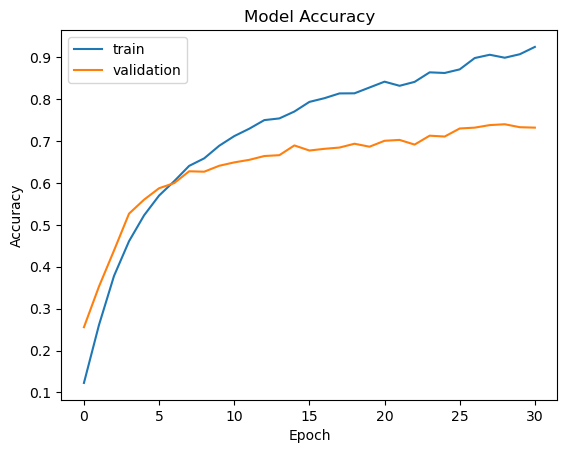

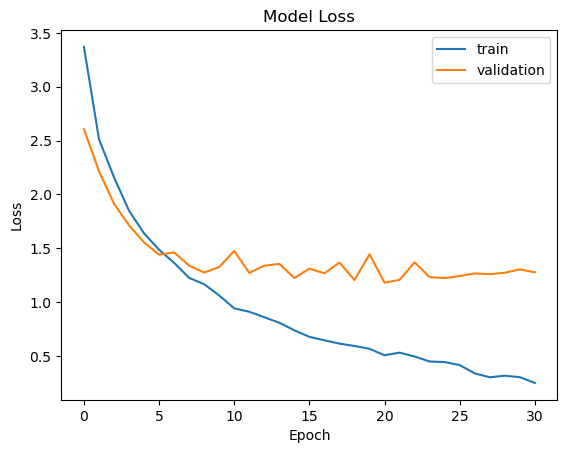

In [25]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

history = custom_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

39/39 [==============================] - 0s 6ms/step
Accuracy of 59.01%


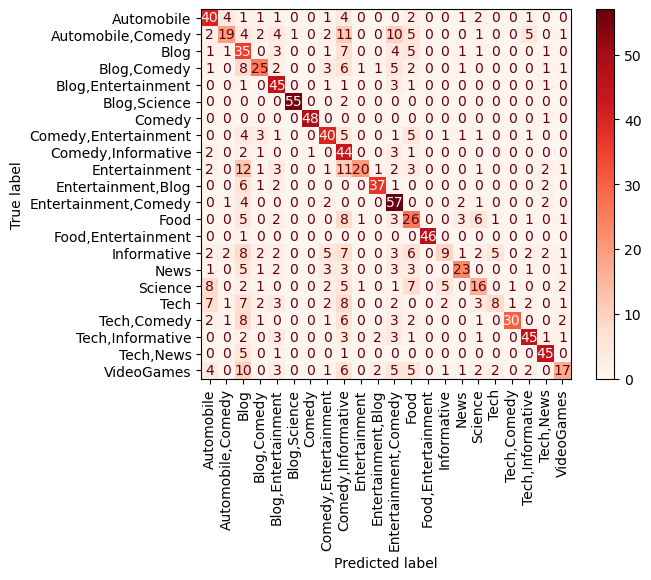

In [26]:
pred = custom_model.predict(x_test)
predictions = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy of {round(acc*100, 2)}%")
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds", xticks_rotation=90)

In [42]:
custom_model.save("./saved_models/v1/custom.h5")

# XAI

In [41]:
for key, value in model_dict.items():
    value.save(f"./saved_models/v1/{key}.h5")

In [28]:
# Images for Dashboard (retrain for Grad and Lime)
image_dirs = [
    "./data/images/NowThis News/t-lMIGV-dUI.jpg",
    "./data/images/The Grand Tour/IDtHjIe13aU.jpg",
    "./data/images/Fireship/ZtyMdRzvi0w.jpg",
    "./data/images/The Office/8GxqvnQyaxs.jpg",
    "./data/images/JRE Clips/VFns39RXPrU.jpg"
]

labels = ["information", "automotive", "technology", "comedy", "blog"]

In [56]:
custom_xai = custom_model
vgg_16_xai = model_vgg_16
inception_xai = model_inception_v3
resnet_xai = model_resnet_50
xception_xai = model_xception

# Grad Cam

In [59]:
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_input
from tensorflow.keras.applications.inception_v3 import  preprocess_input as inception_input
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_input
from tensorflow.keras.applications.xception import  preprocess_input as xception_input

def preprocess_img(img_dir, model_name):
    img = image_method.load_img(img_dir, target_size=(224, 224))
    img = image_method.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    if model_name == 'vgg16':
        return vgg16_input(img)
    elif model_name == 'inception_v3':
        return inception_input(img)
    elif model_name == 'resnet_50':
        return resnet_input(img)
    elif model_name == 'xception':
        return xception_input(img)
    else:
        return img / 255  

def grad_cam(img_array, model, layer_name):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        layer_output, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    gradients = tape.gradient(loss, layer_output)[0]
    casted_layer_output = tf.cast(layer_output > 0, "float32")
    casted_gradients = tf.cast(gradients > 0, "float32")
    guided_gradients = casted_layer_output * casted_gradients * gradients

    # Remove unnecessary dims
    layer_output = layer_output[0]

    weights = tf.reduce_mean(guided_gradients, axis=(0,1))
    grad_cam = tf.reduce_sum(tf.multiply(weights, layer_output), axis=-1)

    width, height = img_array.shape[2], img_array.shape[1]
    heatmap = cv2.resize(grad_cam.numpy(), (width, height))
    counter = heatmap - np.min(heatmap)
    denominator = (heatmap.max() - heatmap.min())

    scaled_heatmap = counter / denominator
    
    return scaled_heatmap

def display_grad_cam(img, heatmap):
    img = image_method.img_to_array(img)
    heatmap = np.uint8(255*heatmap)
    
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = image_method.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = image_method.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.4 + img
    superimposed_img = image_method.array_to_img(superimposed_img)
    
    return superimposed_img

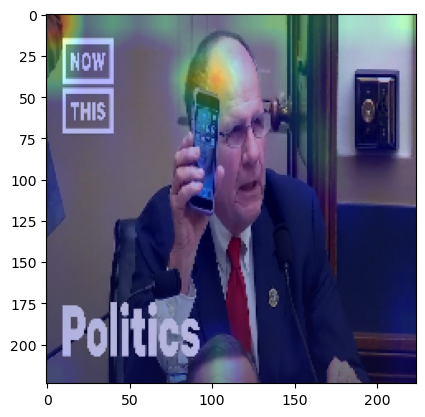

In [57]:
img_value = image_dirs[0]

img_array = preprocess_img(img_value, 'vgg16')
heatmap = grad_cam(img_array, vgg_16_xai, "block5_conv3")

img = image_method.load_img(img_value, target_size=(224, 224))
img = image_method.img_to_array(img)

plt.imshow(display_grad_cam(img, heatmap))

# Code Grave

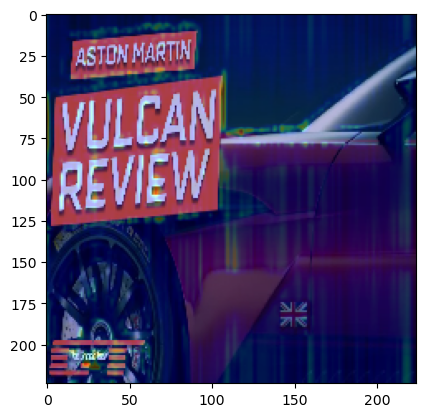

In [70]:
check = image_dirs[1]
img_array = preprocess_img(check, 'custom')
heatmap = grad_cam(img_array, custom_model, "conv2d_867")
img = image_method.load_img(check, target_size=(224, 224))
img = image_method.img_to_array(img)

plt.imshow(display_grad_cam(img, heatmap))

In [67]:
flatten = Flatten()(model_vgg_16.output)
dense1 = Dense(128, activation="relu")(flatten)
dense2 = Dense(64, activation="relu")(dense1)
output = Dense(len(le.classes_), activation="sigmoid")(dense2)

xai_check = Model(inputs=model_vgg_16.input, outputs=output)
xai_check.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
xai_check.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[early_stop, reduce_lr])

Epoch 1/10
124/124 [==============================] - 23s 182ms/step - loss: 2.7189 - accuracy: 0.2606 - val_loss: 2.0816 - val_accuracy: 0.3852 - lr: 0.0010
Epoch 2/10
124/124 [==============================] - 22s 179ms/step - loss: 1.6517 - accuracy: 0.5164 - val_loss: 1.4331 - val_accuracy: 0.5511 - lr: 0.0010
Epoch 3/10
124/124 [==============================] - 22s 181ms/step - loss: 1.2466 - accuracy: 0.6188 - val_loss: 1.3990 - val_accuracy: 0.5915 - lr: 0.0010
Epoch 4/10
124/124 [==============================] - 22s 181ms/step - loss: 1.0080 - accuracy: 0.6911 - val_loss: 1.0166 - val_accuracy: 0.6936 - lr: 0.0010
Epoch 5/10
124/124 [==============================] - 22s 180ms/step - loss: 0.7956 - accuracy: 0.7556 - val_loss: 1.0274 - val_accuracy: 0.6946 - lr: 0.0010
Epoch 6/10
124/124 [==============================] - 22s 181ms/step - loss: 0.6416 - accuracy: 0.7978 - val_loss: 0.9291 - val_accuracy: 0.7351 - lr: 0.0010
Epoch 7/10
124/124 [==============================] 

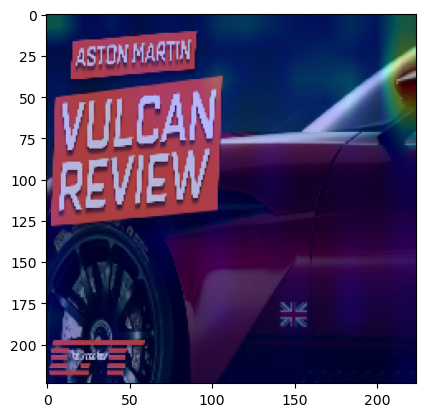

In [69]:
img_value = image_dirs[1]

img_array = preprocess_img(img_value, 'vgg16')
heatmap = grad_cam(img_array, vgg_16_xai, "block5_conv3")

img = image_method.load_img(img_value, target_size=(224, 224))
img = image_method.img_to_array(img)

plt.imshow(display_grad_cam(img, heatmap))